# Семинар № 4 - Задача сегментации

# Imports 

In [ ]:
import os
from pathlib import Path
import random
import typing as tp
from time import gmtime, strftime

import yaml
from tqdm import tqdm
from cv2 import erode
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import rotate, rescale, resize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
set_seed(42)

# Набор данных

Посмотрите на сегодняшнюю задачу: сегментация клеток! Это набор данных [ADDI] (https://www.fc.up.pt/addi/ph2%20database.html). Набор данных содержал медицинские фотографии кожи с родинкой или мелономой. Мы просто сегментируем их по фото, без классификации.

<table><tr><td>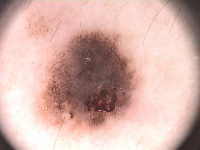</td><td>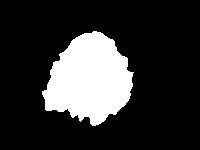</td></tr></table>

## Скачаем данные

1. Для локального запуска

```python
import urllib.request

url = 'https://www.dropbox.com/s/k88qukc20ljnbuo'
filename = 'PH2Dataset.rar'
urllib.request.urlretrieve(url, filename)
```

2. Для google colab и OS

```python
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

get_ipython().system_raw("unrar x PH2Dataset.rar")
```

## Изучим данные

In [ ]:
root = 'PH2Dataset'

# collect all data paths
path = Path(root) / Path('PH2 Dataset images')
image_list_name = sorted(map(str, (path.rglob('*Dermoscopic_Image/*'))))
lesion_list_name = sorted(map(str, (path.rglob('*lesion/*'))))
    
image_list_name = np.array(image_list_name)
lesion_list_name = np.array(lesion_list_name)

print('Amount of images is:', len(image_list_name))

Рассмотрим несколько примеров исходных изображений и их аннотаций

In [ ]:
sample_idx = np.random.randint(0, len(image_list_name), 1)[0]

sample_image_name = image_list_name[sample_idx]
sample_image = imread(sample_image_name)

sample_lesion_name = lesion_list_name[sample_idx]
sample_lesion = imread(sample_lesion_name)

s = f'Image shae: {sample_image.shape}, \nLesion shape: {sample_lesion.shape}'
print(s) 

In [ ]:
plt.subplot(121)
plt.imshow(sample_image)
plt.subplot(122)
plt.imshow(sample_lesion)
plt.show()

In [ ]:
transformed_lesion = (rotate(sample_lesion, 40))

print(transformed_lesion.shape, sample_lesion.shape)

plt.subplot(121)
plt.imshow(sample_lesion)
plt.subplot(122)
plt.imshow(transformed_lesion)
plt.show()

## Метрики

### IoU

Давайте рассмотрим наиболее похожую метрику сегментации — Intersection over Union (IoU). Визуальная интерпретация показана на изображении ниже:

![iou](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

In [ ]:
truth = sample_lesion / sample_lesion.max()
predict = transformed_lesion / transformed_lesion.max()

In [ ]:
t = (truth.flatten() > 0.5)
p = (predict.flatten() > 0.5)

In [ ]:
iou = ...
iou

### Dice

Еще одна метрика сегментации — Dice, которая очень похожа на IoU и показана на изображении ниже:

![](https://miro.medium.com/max/858/1*yUd5ckecHjWZf6hGrdlwzA.png)

In [ ]:
dice = ...
dice

### F1

Напомним, что $F_{\beta}$ score is:

$$ F_{\beta} = (1 + {\beta}^2) \frac{Precision * Recall}{{\beta}^2 * Precision + Recall} $$

In [ ]:
inter = ...
prec = ...

prec

In [ ]:
rec = ...
rec

In [ ]:
f1 = ...
f1

## Морфологические трансформации

Морфологическое преобразование — полезный набор инструментов для улучшения масок или семантических карт. Если маска зашумлена, мы можем удалить ошибочные точки эрозией.

In [ ]:
thr =  0.5  # threshold value
transformed_lesion = rotate(sample_lesion, 40)

# create noise
noise = np.random.randn(*(s // 20 for s in sample_lesion.shape))
noise = rescale(noise, 30)[:sample_lesion.shape[0], :sample_lesion.shape[1]]
noised_mask = 0.7 * transformed_lesion + 0.3 * noise

# min-max normalization
noised_mask = (noised_mask - noised_mask.min()) / (noised_mask.max() - noised_mask.min())

# plot results
_, ax = plt.subplots(1, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))

ax[0].imshow(sample_lesion, cmap="gray")
ax[1].imshow(transformed_lesion > thr, cmap="gray")
ax[2].imshow(noised_mask > thr, cmap="gray")
plt.show()

Как работает операция эрозии?

In [ ]:
kernel = np.ones((3, 3)).astype(np.uint8)
print(f"Kernel:\n{kernel}")

example = np.ones((10, 10))
example[3, 4] = 0
print(f"Example:\n{example}")

padded_example = np.zeros((12, 12))
padded_example[1:11, 1:11] = example
result = np.zeros((10, 10)) 
for i in range(10):
    for j in range(10):
        result[i, j] = np.min(padded_example[i:i + 3, j:j + 3] * kernel)

print(f"Result:\n{result}")

Теперь применим это для маски.

In [ ]:
kernel = np.ones((5, 5)).astype(np.uint8)
eroded = erode((noised_mask * 255).astype(np.uint8), kernel, iterations=5) / 255

_, ax = plt.subplots(1, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))

ax[0].imshow(sample_lesion, cmap="gray")
ax[1].imshow(noised_mask > thr, cmap="gray")
ax[2].imshow(eroded > thr, cmap="gray")
plt.show()

## Data Augmentation


In [ ]:
import typing as tp
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images: np.array, 
                 masks: tp.Optional[np.array] = None,
                 transforms: tp.Optional[A.BasicTransform] = None):
        self.image_fname_list = images
        self.mask_fname_list = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_fname_list)

    def __getitem__(self, idx: int) -> dict:
        image = imread(self.image_fname_list[idx])
        mask = imread(self.mask_fname_list[idx])
        mask = mask / mask.max()
        
        # pass your code
        pass

        return image, label

## Albu

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 as ToTensor

In [ ]:
def pre_transform(image_size: int = 256) -> A.BasicTransform:
    return A.Resize(image_size, image_size, always_apply=True)


def augmentations() -> A.BasicTransform:
    channel_augs = [
        A.HueSaturationValue(hue_shift_limit=10, 
                             sat_shift_limit=10,
                             val_shift_limit=10, 
                             p=0.5),
        A.ChannelShuffle(p=0.5),
    ]

    result = [
        # pass your code
        pass
    ]
    return A.Compose(result)


def post_transform() -> A.BasicTransform:
    return A.Compose([
        A.Normalize(mean=0, 
                    std=1,
                    max_pixel_value=255),
        ToTensor()
    ])

In [ ]:
# Create train pipeline
image_size = 256
train_transformation = A.Compose([
    pre_transform(image_size), augmentations(), post_transform()
])


# Create valid pipeline
valid_transformation = A.Compose([
    pre_transform(image_size), post_transform()
])  

Прежде чем тренироваться - нарисуйте некоторые результаты аугментации. Всегда проверяйте это!Прежде чем тренироваться - нарисуйте некоторые результаты аугментации. Всегда проверяйте это!

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(6.4 * 1.5, 4.8 * 1.5))

for i in range(4):
    aug_image = train_transformation(image=sample_image)["image"].permute(1, 2, 0).numpy()
    ax[i % 2][i // 2].imshow(aug_image)
    
plt.show()

Еще один важный момент - проверьте аугментацию маски.Еще один важный момент - проверьте аугментацию маски.

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(6.4 * 1.5, 4.8 * 1.5))

for i in range(4):
    aug_mask = train_transformation(image=sample_image, 
                                     mask=sample_lesion)["mask"].numpy()
    ax[i % 2][i // 2].imshow(aug_mask)
    
plt.show()

In [ ]:
batch_size = 8
num_workers = 0  # num_workers = 0 for local notebook on win 

indexes = np.arange(len(image_list_name))
np.random.shuffle(indexes)
train_indexes = indexes[:int(0.8 * len(image_list_name))]
valid_indexes = indexes[int(0.8 * len(lesion_list_name)):]

In [ ]:
train_dataset = SegmentationDataset(
    image_list_name[train_indexes],
    lesion_list_name[train_indexes],
    train_transformation
)
train_loader = DataLoader(
    train_dataset, 
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

valid_dataset = SegmentationDataset(
    image_list_name[valid_indexes],
    lesion_list_name[valid_indexes],
    valid_transformation
) 
valid_loader = DataLoader(
    valid_dataset, 
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

Check data loaders!

In [ ]:
image, mask = next(iter(train_loader))

print('Image batch shape:', image.shape)
print('Mask batch shape:', mask.shape)

# Создание модели U-Net

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lvXoKMHoPJMKpKK7keZMEA.png)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=10):
        super().__init__()
        pass


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pass
        
        return None

In [ ]:
def init_scratch_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

Check model

In [ ]:
model = UNet(in_channels=3, n_classes=10)

x = torch.ones((8, 3, 256, 256))  # dummy input
out = model(x)
print(out.shape)

out = out.detach()
out = torch.sigmoid(out)

In [ ]:
image, mask = next(iter(train_loader))

print('Image batch shape:', image.shape)
print('Mask batch shape:', mask.shape)

out = model(image)

Check results

In [ ]:
image = out.detach().data[0, ...]
print(image.shape)
image = image.permute(1, 2, 0).numpy()

plt.imshow(image[..., 6])
plt.show()

# Train loop

In [ ]:
def iou_per_channel(inputs, targets, threshold=0.5, eps=1e-8):
    # pass your code
    iou = 0
    return iou


def iou_metric(probability, truth, threshold=0.5):
    batch_size = truth.shape[0]
    channel_num = truth.shape[1]
    mean_iou_channel = 0.
    all_channels = []
    
    with torch.no_grad():
        for i in range(batch_size):
            for j in range(channel_num):
                channel_iou = iou_per_channel(probability[i, j, :, :], truth[i, j, :, :], threshold)
                all_channels.append(channel_iou)
                mean_iou_channel += channel_iou / (batch_size * channel_num)
    return mean_iou_channel

In [ ]:
class BaseTrainProcess:
    def __init__(self, hyp):
        start_time = strftime("%Y-%m-%d %H-%M-%S", gmtime())
        log_dir = (Path("logs") / start_time).as_posix()
        print('Log dir:', log_dir)
        self.writer = SummaryWriter(log_dir)
        
        self.best_loss = 1e100
        self.best_acc = 0.0
        self.current_epoch = -1
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.hyp = hyp

        self.lr_scheduler: Optional[torch.optim.lr_scheduler] = None
        self.model: Optional[torch.nn.modules] = None
        self.optimizer: Optional[torch.optim] = None
        self.criterion: Optional[torch.nn.modules] = None

        self.train_loader: Optional[Dataloader] = None
        self.valid_loader: Optional[Dataloader] = None

        self.init_params()
        
    def _init_data(self):
        train_dataset = SegmentationDataset(
            image_list_name[train_indexes],
            lesion_list_name[train_indexes],
            train_transformation
        )

        valid_dataset = SegmentationDataset(
            image_list_name[valid_indexes],
            lesion_list_name[valid_indexes],
            valid_transformation
        ) 

        self.train_loader = DataLoader(train_dataset,
                                       batch_size=self.hyp['batch_size'], 
                                       shuffle=True,
                                       num_workers=self.hyp['n_workers'])

        self.valid_loader = DataLoader(valid_dataset,
                                     batch_size=self.hyp['batch_size'], 
                                     shuffle=True, 
                                     num_workers=self.hyp['n_workers'])
    
    def _init_model(self):
        self.model = UNet(in_channels=3, n_classes=1)
        self.model.apply(init_scratch_weights)
        self.model.to(self.device)
        
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hyp['lr'],
                                         weight_decay=self.hyp['weight_decay'])

        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min')
        
    def init_params(self): 
        self._init_data()
        self._init_model()
    
    def save_checkpoint(self, loss_valid, path):
        if loss_valid[0] <= self.best_loss:
            self.best_loss = loss_valid[0]
            self.save_model(path)

    def save_model(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.mainscheduler.state_dict()
        }, path)
    
    def train_step(self):
        self.model.train()
        self.optimizer.zero_grad()
        self.model.zero_grad()

        cum_loss = 0.0
        cum_acc = 0.0
        
        proc_loss = 0.0
        proc_acc = 0.0
        
        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader), 
                    desc=f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}')        
        for idx, (images, labels) in pbar:
            images, labels = images.to(self.device), labels.to(self.device)
            
            with torch.set_grad_enabled(True):
                logit = self.model(images)
                loss = self.criterion(logit, labels)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.model.zero_grad()
                
            cur_loss = loss.detach().cpu().numpy()
            prob, pred = torch.softmax(logit.detach(), dim=1).topk(k=1)
            acc = iou_metric(prob, labels)
            cum_acc += acc
    
            cum_loss += cur_loss
        
            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)
            proc_acc = (proc_acc * idx + acc) / (idx + 1)
        
            s = f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}, F1: {proc_acc:4.3f}, BCE: {proc_loss:4.3f}'
            pbar.set_description(s)
            
        cum_loss /= len(self.train_loader)
        cum_acc /= len(self.train_loader)
        return [cum_loss, cum_acc]
    
    def valid_step(self):
        # TODO: add your code
        self.model.eval()
        
        cum_loss = 0.0
        cum_acc = 0.0
        
        proc_loss = 0.0
        proc_acc = 0.0
        
        pbar = tqdm(enumerate(self.valid_loader), total=len(self.valid_loader), 
                    desc=f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}')
        for idx, (images, labels) in pbar:
            images, labels = images.to(self.device), labels.to(self.device)
            
            with torch.set_grad_enabled(False):
                logit = self.model(images)
                loss = self.criterion(logit, labels)
                
            cur_loss = loss.detach().cpu().numpy()
            prob, pred = torch.softmax(logit.detach(), dim=1).topk(k=1)
            acc = iou_metric(prob, labels)
            cum_acc += acc
    
            cum_loss += cur_loss
        
            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)
            proc_acc = (proc_acc * idx + acc) / (idx + 1)
        
            s = f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}, F1: {proc_acc:4.3f}, BCE: {proc_loss:4.3f}'
            pbar.set_description(s)
            
        cum_loss /= len(self.valid_loader)
        cum_acc /= len(self.valid_loader)
        return [cum_loss, cum_acc]
    
    def run(self):
        best_w_path = 'best.pt'
        last_w_path = 'last.pt'
        
        train_losses = []
        valid_losses = []

        for epoch in range(self.hyp['epochs']):
            self.current_epoch = epoch

            loss_train = self.train_step()
            train_losses.append(loss_train)
                
            self.lr_scheduler.step()
            lr = optimizer.param_groups[0]["lr"]

            loss_valid = self.valid_step()
            valid_losses.append(loss_valid)
            
            self.save_checkpoint(loss_valid, best_w_path)
            
            self.writer.add_scalar('Train/Loss', loss_train[0], epoch)
            self.writer.add_scalar('Valid/Loss', loss_valid[0], epoch)
            self.writer.add_scalar('Lr', lr, epoch)

        self.save_model(last_w_path)
        torch.cuda.empty_cache()
        self.writer.close()

        return train_losses, valid_losses

In [ ]:
with open('hyp_params.yaml', 'r') as f:
    hyps = yaml.load(f, Loader=yaml.SafeLoader)
    
print(hyps)

In [ ]:
set_seed(hyps['seed'])

trainer = BaseTrainProcess(hyps)

In [ ]:
train_losses, valid_losses = trainer.run()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6006